[진행 상황]
1. 동영상을 재생하여 프레임 저장
 - 프레임 한 개를 불러와 마우스로 x,y,w,h 좌표를 추출
2. 좌표를 통해 roi 설정
2. 동영상 frame을 gray scale 후 roi 영역에는 binary scale 추가
4. 1, 2, 3루의 중앙 좌표 설정
      - roi 내 누상의 중앙 좌표는 모든 방송사가 거의 같기 때문에 바꾸지 않아도 됨 
3. <조건>
 - 피칭 장면일 때만 True
 - 미리 지정한 사진 (누상 사진)과 이미지 템플릿 매칭
      - roi 영역 내 누상만 검출하기 위해서
 - 이전 frame과 현재 프레임 비교
      - "1루에서 2루" 등 누상이 바뀌는 부분 검출하기 위해서
4. 다음 피칭 시점에서 누상 바뀐 frame 폴더에 저장

[문제] 
 - OUT과 점수가 난 상황을 감지 못함

[목표]
1. 다음 피칭 시점에서 현재 시점으로 바꾸기
2. 논문 확장 시 : roi 좌표를 입력하지 않고 검출할 수 있게 하기 (모델 학습)
   - 효과 : 누상이 없는 부분을 검출하지 않음
3. 점수가 났을 때와 OUT 됐을 때 구분하기

In [1]:
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # 초기화 할 GPU Number
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess = tf.compat.v1.Session(config=config)

from tensorflow.keras.models import load_model
from collections import deque
import numpy as np
import pickle
import pandas as pd
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json
import pytesseract
from PIL import Image

In [2]:
model = load_model('./paper_data')
classes = os.listdir('./paper_dataset/train')

In [36]:
# model = load_model('./first_try.h5')
print(os.listdir('./paper_dataset/train'))
# lb = pickle.loads(open('./video_classification_model/model/BaseballPickle.pickle', 'rb').read())
outputvideo = "./video/demo_output.avi"
# # mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
# Queue = deque(maxlen=128)#좌표
# def convert(x, y, w, h):
#     a=(x-0.5*(w))*1280
#     b=(y-0.5*(h))*720
#     c=a+(w*1280)
#     d=b+(h*720)
#     return (a, b, c, d)
# x,y,w,h = convert(0.925000,0.851852,0.033333,0.040741)

# #  scoreboard 점수 좌표
# home = convert(0.069531, 0.123611, 0.025000, 0.047222) #mbcs 1280x720 home
# away = convert(0.125000, 0.124306, 0.021875, 0.048611) #mbcs 1280x720 away

def frame_to_time(count):
    sec = count / 29.97
    mit = int(sec) / 60
    hour = int(mit) / 60
    hour = int(hour)
    mit = int(mit) - 60 * hour
    sec = int(sec) - 3600 * hour - 60 * int(mit)
    return sec, mit, hour

x1=71; y1=72; w1=111; h1=106; # nc
x2=142; y2=73; w2=182; h2=106; # nc
# x1=1081; y1=593;w1=1111;h1=622 # kia kium
# x2=1081; y2=625;w2=1110;h2=656 # kia kium
h_area = x1, y1, w1, h1
a_area = x2, y2, w2, h2
print(h_area, a_area)

['not_pitching', 'pitching']
(71, 72, 111, 106) (142, 73, 182, 106)


In [37]:
# 스코어보드 이미지 템플릿 매칭

def template_matching(gimoon, template): # src: 들어갈 이미지 또는 프레임, template: 템플릿 이미지
    flag = False
    src = cv2.cvtColor(gimoon, cv2.COLOR_BGR2GRAY)
#     print(src[25][38], src[10][27], src[23][10])
#     cv2.imshow('src',src)
    result = cv2.matchTemplate(src, template, cv2.TM_SQDIFF_NORMED)
#     cv2.imshow('src',src)
    threshold = 0.08
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(result)

    if minVal < threshold:
        flag = True
    
    return flag

In [38]:
# 직전 프레임과 현재 프레임 비교

def prev_frame(biimg, count):         
    global nowFrame   
    global preFrame
       
    preFrame_1 = []
    preFrame_2 = []
    nowFrame_1 = []
    nowFrame_2 = []
    
    compare_Frame = []
       
    if (count % 2 == 1):
# 현재 프레임의 1, 2, 3루의 RGB값 3x3 배열로 저장
        nowFrame = []
        nowFrame_1 = np.hstack([biimg[25][38],biimg[20][27]])
        
        nowFrame_2 = np.hstack([nowFrame_1,biimg[23][10]])
        nowFrame = nowFrame_2
    else:
# 3개 전 프레임의 1, 2, 3루의 RGB값 3x3 배열로 저장
        preFrame = []
        preFrame_1 = np.hstack([biimg[25][38],biimg[20][27]])
        preFrame_2 = np.hstack([preFrame_1,biimg[23][10]])
        preFrame = preFrame_2
#     print("now, pre",nowFrame, preFrame)
# 이전 프레임과 현재 프레임 비교

    if np.array_equal(preFrame, nowFrame):
        compareFrame = False
    else:
        compareFrame = True

    return compareFrame

In [44]:
# main

# ./video/NCvs두산풀경기.mp4
# C:/Users/user/Downloads/KT vs LG 풀경기.mp4'
cap = cv2.VideoCapture('./video/NCvs두산풀경기.mp4')
template = cv2.imread('./0roo/1(3).jpg', cv2.IMREAD_GRAYSCALE)

curTime = time.time()
nowFrame = []
preFrame = []

# x=248; y=42; w=295; h=76 # KT vs LG
# x=1154; y=590; w=1197; h=622
x=136; y=139; w=187; h=179 # nc vs 두산
# x=1161; y=600; w=1207; h=628 # kia 키움(mbcS)
start_frame = 120000
count = start_frame
tesser_count = start_frame
change_cnt = 0
change_cnt11 = change_cnt
change_log = {}
writer = None
(Width, Height) = (None, None)

h_score = 0
a_score = 0
tag_count = 0

init = True

# 원하는 프레임부터 동영상 재생
cap.set(cv2.CAP_PROP_POS_FRAMES, count)

while cv2.VideoCapture():
    taken, frame = cap.read()
    gimoon = frame.copy()
    roi = gimoon[y:h, x:w] 
    cv2.rectangle(gimoon, (x,y), (w-1, h-1), (0,255,0), 1)
#     ret, frame = cap.read()
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame.astype('float32') / 255, (224, 224))

    score1_roi = gimoon[y1:h1, x1:w1]
    score2_roi = gimoon[y2:h2, x2:w2]
    cv2.rectangle(gimoon, (x1,y1), (w1-1, h1-1), (0,255,0), 1)
    cv2.rectangle(gimoon, (x2,y2), (w2-1, h2-1), (0,255,0), 1)
    
      
    predict = model.predict(frame[np.newaxis]) #np.expand_dims(frame, axis=0))
    label = 'not pitching' if np.argmax(predict) == 0 else 'pitching'
    if not taken:
        break
    if Width is None or Height is None:
        (Width, Height) = frame.shape[:2]
        
    if count % 3 == 0:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame.astype('float32') / 255, (224, 224))
        frame_2 = gimoon.copy()
    #     text = "Activity: {}".format(label)
    #     cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (0, 255, 0), 5)

#         if writer is None:
#             fourcc = cv2.VideoWriter_fourcc(*"MJPG")
#             writer = cv2.VideoWriter(outputvideo, fourcc, 30, (Width, Height), True)

#         writer.write(output)
       
        if label == 'pitching':
            if count % 3 == 2:
                if tag_count < count-30:
                    cv2.imwrite('./mbcS_KvsK/%d.jpg' % count, gimoon)
                    frame_2 = cv2.imread('./mbcS_KvsK/%d.jpg' % count)
                    frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2GRAY)
                    frame_2 = cv2.threshold(frame_2, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

                    cv2.imwrite('./mbcS_KvsK/%d.jpg' % count, gimoon)
                    pre_h_score = h_score
                    pre_a_score = a_score

                    # 홈, 어웨이 스코어좌표 추출 및 이미지 저장
                    image = Image.open('./mbcS_KvsK/%d.jpg' % count)
                    h_img = image.crop(h_area)
                    h_img.save('./mbcS_KvsK/score/%d_h_img.jpg' % count)
                    a_img = image.crop(a_area)
                    a_img.save('./mbcS_KvsK/score/%d_a_img.jpg' % count)

                    # pytesseract를 활용한 숫자 검출
                    h_result = pytesseract.image_to_string('./mbcS_KvsK/score/%d_h_img.jpg' %count, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
                    h_score = h_result[:1]
                    a_result = pytesseract.image_to_string('./mbcS_KvsK/score/%d_a_img.jpg' %count, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
                    a_score = a_result[:1]

                    # 아무 값을 추출하지 못할때 0의 경우이기에 점수값을 0으로 변환
                    if h_score == '\x0c':
                        h_score = '0'
                    if a_score == '\x0c':
                        a_score = '0'
                    if pre_h_score == '\x0c':
                        pre_h_score = '0'
                    if pre_a_score == '\x0c':
                        pre_a_score = '0'
                    print(h_score)
                    print(a_score)
                    
                    # 이전 점수값과 비교하여 점수 변화 검출
                    if int(pre_h_score) < int(h_score) or int(pre_a_score) < int(a_score):       
                        if int(h_score) <= int(int(pre_h_score) + int(4)) and int(a_score) <= int(int(pre_a_score) + int(4)):
                            if int(pre_h_score) != int(h_score) or int(pre_a_score) != int(a_score):
                                sec, mit, hour = frame_to_time(tag_count)
                                print(hour, "시간", mit, "분", sec, "초 *점수 변화 발생")
                                print("Score changed, Home:", h_score, 'Away:', a_score)

                tag_count = count
                
            if template_matching(gimoon, template):
                print("템플릿 매칭 완료")
                _, bin_roi = cv2.threshold(roi, 127, 255, cv2.THRESH_BINARY) # 색 빼고 다 흰색 및 검정
                hsv_roi = cv2.cvtColor(bin_roi, cv2.COLOR_BGR2HSV) # 채도 변경
                gray_roi = cv2.cvtColor(hsv_roi, cv2.COLOR_BGR2GRAY) # 그레이 스케일
                _, biimg = cv2.threshold(gray_roi, 127, 255, cv2.THRESH_BINARY)

                nusang = ""
                base_1 = np.array_equal(biimg[25][38], 255) # 1루 False: 변화 X, True: 변화 O
                base_2 = np.array_equal(biimg[10][27], 255) # 2루 False: 변화 X, True: 변화 O
                base_3 = np.array_equal(biimg[23][10], 255) # 3루 False: 변화 X, True: 변화 O 
                base_0 = np.array_equal(np.hstack([np.hstack([biimg[25][38],biimg[20][27]]),biimg[23][10]]), [0,0,0])

                compareFrame = prev_frame(biimg, count)

                if init: # 키 안에 첫 값일 경우
                    change_log[change_cnt] = [count] # 누상 저장 되는 프레임
                    init = False
                else:
                    change_log[change_cnt].append(count)
                    print(change_log)
                    if len(change_log[change_cnt]) > 2: # 키 안의 리스트 값을 2개로 유지하기 위함
                        change_log[change_cnt].pop(0)

                if compareFrame:
                    print("프레임 비교 완료")
                    if base_1:
                        nusang += "1루 변화 "
                        change_cnt += 1
                        init = True
                        with open('./change_logs/change_logs10.json', 'w', encoding='utf-8') as make_file:
                            json.dump(change_log, make_file, indent='\t')
                    if base_2:
                        nusang += "2루 변화 "
                        change_cnt += 1
                        init = True
                        with open('./change_logs/change_logs10.json', 'w', encoding='utf-8') as make_file:
                            json.dump(change_log, make_file, indent='\t')
                    if base_3:
                        nusang += "3루 변화 "
                        change_cnt += 1
                        init = True
                        with open('./change_logs/change_logs10.json', 'w', encoding='utf-8') as make_file:
                            json.dump(change_log, make_file, indent='\t')
                    if base_0:
                        nusang += "득점, 홈런, 아웃, 다음 이닝 변화"
                        change_cnt += 1
                        init = True
                        with open('./change_logs/change_logs10.json', 'w', encoding='utf-8') as make_file:
                            json.dump(change_log, make_file, indent='\t')

                print(nusang,"\n")
                if len(nusang) != 0:
                    cv2.imwrite("./frame/ddd/frame_{:06d}.jpg".format(count), biimg)

        cv2.imshow('frame',gimoon)
    if cv2.waitKey(1) &0xFF == ord('q'):
        break
    
#     cv2.imshow("In progress", output)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

    count += 1
        
print("Finalizing.......")
# writer.release()
cap.release()
cv2.destroyAllWindows()

이이잉~1
템플릿 매칭 완료
프레임 비교 완료
1루 변화 2루 변화  

이이잉~1
템플릿 매칭 완료
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120063, 120066]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120063, 120066, 120069]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120066, 120069, 120072]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120069, 120072, 120075]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120072, 120075, 120078]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120075, 120078, 120081]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120078, 120081, 120084]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120081, 120084, 120087]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120084, 120087, 120090]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120087, 120090, 120093]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120090, 120093, 120096]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120093, 120096, 120099]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120096, 120099, 120102]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120099, 120102, 120111]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120102, 120111, 120114]}
 

이이잉~1
템플릿 매칭 완료
{0

템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122535, 122538, 122541]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122538, 122541, 122544]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122541, 122544, 122547]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122544, 122547, 122550]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122547, 122550, 122553]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122550, 122553, 122556]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122553, 122556, 122559]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122556, 122559, 122562]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122559, 122562, 122565]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122562, 122565, 122568]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122565, 122568, 122571]}
 

이이잉~1
템플릿 매칭 완료
{0: [120036], 2: [120381, 122463], 4: [122568, 122571, 122574]}
 

이이잉~1
템플릿 

In [24]:
# 저장된 프레임의 원본 동영상의 시간으로 Change
import json
import os

def hms(s):
    hours = s // 3600
    s = s - hours*3600
    mu = s // 60
    ss = s - mu*60
    return f'{str(hours).zfill(2)}:{str(mu).zfill(2)}:{str(ss).zfill(2)}'

save_dir = './change_logs/change_logs3.json'

with open(save_dir, 'r') as f:
    json_data = json.load(f)

pitching_frame_list = [] 
check_img = []

for v in json_data.values():
#     print(v)
    if len(v) != 1:
        if v[1] - v[0] > 90:
            pitching_frame_list.append(v[0])
            check_img.append(v[0])
            check_img.append(v[1])

pitching_time_list = list(map(lambda x: round(x/29.97), pitching_frame_list))

with open('./change_logs/change_logs_time3.txt', 'w') as f: # 누상변화 타임스탬프 txt 파일로 저장
    for x in pitching_time_list:
        f.write(f'{hms(x)}\n')
        print(hms(x))

cap = cv2.VideoCapture('./video/NCv두산풀경기.mp4')

# for x in check_img:
#     if os.path.isfile(f'./누상변화2/{x}.jpg') == False:
#         frame = x
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frame) # 2번째 인자가 프레임 인덱스 -> 변경해서 장면 찾기 

#         ret, image = cap.read()

#         cv2.imwrite(f'./누상변화2/{frame}.jpg', image) # 지정한 프레임 저장

cap.release()
cv2.destroyAllWindows()

00:18:58
00:22:26
00:31:04
00:43:05
00:44:44
00:51:58
00:53:46
01:02:12
01:04:24
01:06:57
01:09:34
01:12:04
01:34:56
01:42:27
01:46:22
01:47:23
01:56:57
02:08:24
02:26:43
02:35:57
02:40:11
02:44:22
02:58:00
03:00:25
03:03:32
03:16:38
03:31:00
03:35:54
03:38:13
03:45:37


## 동영상 재생하여 좌표 추출하기

In [17]:
import cv2
cap1 = cv2.VideoCapture('C:/Users/user/Downloads/롯데 vs 삼성 풀경기.mp4')
count = 0

# 원하는 프레임부터 동영상 재생
cap1.set(cv2.CAP_PROP_POS_FRAMES, 76000)

while cv2.VideoCapture():
     
    ret, frame = cap1.read()
    cv2.imshow("frame",frame)
    cv2.imwrite("./save_frame/frame_{:06d}.jpg".format(count), frame)
    if cv2.waitKey(1) &0xFF == ord('q'):
        break

    count += 1   

cap1.release()
cv2.destroyAllWindows() 

In [1]:
import cv2
import numpy as np

isDragging = False
x0,y0,w,h = -1,-1,-1,-1
blue,red = (255,0,0),(0,0,255)

def onMouse(event, x,y,flags, param):
    global isDragging,x0,y0,img
    if event ==cv2.EVENT_LBUTTONDOWN:
        isDragging=True
        x0=x
        y0=y
    elif event==cv2.EVENT_MOUSEMOVE:
        if isDragging:
            img_draw=img.copy()
            cv2.rectangle(img_draw,(x0,y0),(x,y),blue,1)
            cv2.imshow('img',img_draw)
    elif event== cv2.EVENT_LBUTTONUP:
        if isDragging:
            isDragging=False
            yet_w=x-x0
            yet_h=y-y0
            w = yet_w + x0
            h = yet_h + y0
            print('x:%d, y%d,w:%d,h:%d'%(x0,y0,w,h))
            if w>0 and h>0:
                img_draw= img.copy()
                cv2.rectangle(img_draw,(x0,y0),(x,y),red,1)
                cv2.imshow('img',img_draw)
                roi = img[y0:y0+h,x0:x0+w]
                cv2.imshow('cropped',roi)
                cv2.moveWindow('cropped',0,0)
                cv2.imwrite('./cropped.jpg',roi)
                print('cropped')
            else:
                cv2.imshow('img',img)
                print("좌측상단에서 우측하단으로 영역을 드래그하세요")
img=cv2.imread('./save_frame/frame_000000.jpg')
cv2.imshow('img',img)

cv2.setMouseCallback('img',onMouse)
cv2.waitKey()
cv2.destroyAllWindows()

x:234, y40,w:294,h:80
cropped


In [53]:
srca = cv2.imread("./0roo/crop.jpg")
ret, a = cv2.threshold(srca, 127, 255, cv2.THRESH_BINARY) # 색 빼고 다 흰색 및 검정
b = cv2.cvtColor(a, cv2.COLOR_BGR2HSV) # 채도 변경
ret, c = cv2.threshold(b, 127, 255, cv2.THRESH_BINARY) # 1채널
d = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY) # 그레이 스케일
# print(c[25][38], "1") # 1루 False: 변화 X, True: 변화 O
# print(c[10][27], "2") # 2루 False: 변화 X, True: 변화 O
# print(c[23][10], "3")

# print(c)
cv2.imshow("a", a)
cv2.imshow("d", d)
cv2.imshow("c", c)
cv2.imshow("b", b)
cv2.imshow("srca", srca)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
import cv2
import matplotlib.pyplot as plt
# x=1114; y=592;w=1211; h=655
src1 = cv2.imread("./0roo/try (3).jpg", 0)
# roi = src1[y:h, x:w]
# a = cv2.rectangle(src1, (x,y), (w-1, h-1), (0,255,0), 1)
templit = cv2.imread("./0roo/1(5).jpg", 0)
dst = cv2.imread("./0roo/try (3).jpg")
# CV_TM_CCORR_NORMED , SQDIFF_NORMED , CCOEFF_NORMED
result = cv2.matchTemplate(src1, templit, cv2.TM_SQDIFF_NORMED)

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(result)
x, y = minLoc
h, w = templit.shape

dst = cv2.rectangle(dst, (x, y), (x +  w, y + h) , (0, 0, 255), 2)
# cv2.imshow("src1", src1)
cv2.imshow("dst", dst)
# cv2.imshow("temp", templit)
# cv2.imshow("src1", src1)
print("원본 이미지 size", dst.shape)
print("템플릿 이미지 size", templit.shape)

cv2.waitKey(0)
cv2.destroyAllWindows()

원본 이미지 size (720, 1280, 3)
템플릿 이미지 size (40, 61)


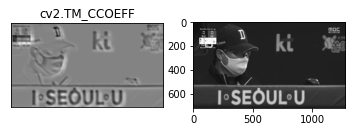

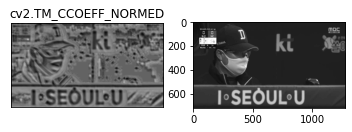

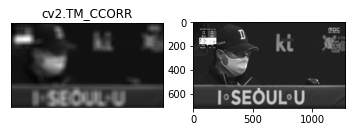

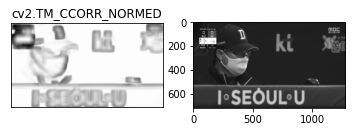

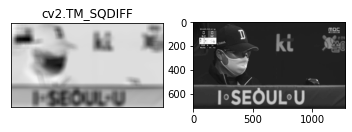

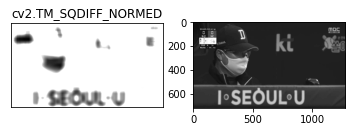

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('./0roo/1.jpg',0)
img2 = img.copy()
template = cv2.imread('./0roo/1(3).jpg',0)

# template 이미지의 가로/세로
w,h = template.shape[::-1]

# Template Match Method
methods = ['cv2.TM_CCOEFF','cv2.TM_CCOEFF_NORMED','cv2.TM_CCORR','cv2.TM_CCORR_NORMED','cv2.TM_SQDIFF','cv2.TM_SQDIFF_NORMED']
# 'cv2.TM_CCOEFF','cv2.TM_CCOEFF_NORMED','cv2.TM_CCORR','cv2.TM_CCORR_NORMED',
for meth in methods:
    img = img2.copy()
    method = eval(meth)

    res = cv2.matchTemplate(img,template,method)
    min_val,max_val,min_loc, max_loc = cv2.minMaxLoc(res)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc

    bottom_right = (top_left[0]+w,top_left[1]+h)
    cv2.rectangle(img,top_left,bottom_right,255,8)

    plt.subplot(121),plt.title(meth),plt.imshow(res,cmap='gray'),plt.yticks([]),plt.xticks([])
    
    plt.subplot(122),plt.imshow(img,cmap='gray')
    plt.show()